In [14]:
import numpy as np
from sklearn.model_selection import train_test_split

random_state = 42


def f1(x):
    return x * np.sin(x) + 2 * x


def f2(x):
    return 10 * np.sin(x) + x ** 2


def f3(x):
    return np.sign(x) * (x ** 2 + 300) + 20 * np.sin(x)


def create_analytical_dataset(func, n_samples=100, random_state=random_state):
    tr = 20
    X = np.linspace(-tr, tr, n_samples)
    y = func(X)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, train_size=0.7, random_state=random_state, shuffle=True
    )

    y_test = y_test[X_test.argsort()]
    X_test.sort()

    return X_train, X_test, y_train, y_test


functions = [f1, f2, f3]
datasets = {}

for i, f in enumerate(functions, 1):
    X_train, X_test, y_train, y_test = create_analytical_dataset(f)
    datasets[f'f{i}'] = {
        'X_train': X_train, 'y_train': y_train,
        'X_test': X_test, 'y_test': y_test,
        'function': f
    }

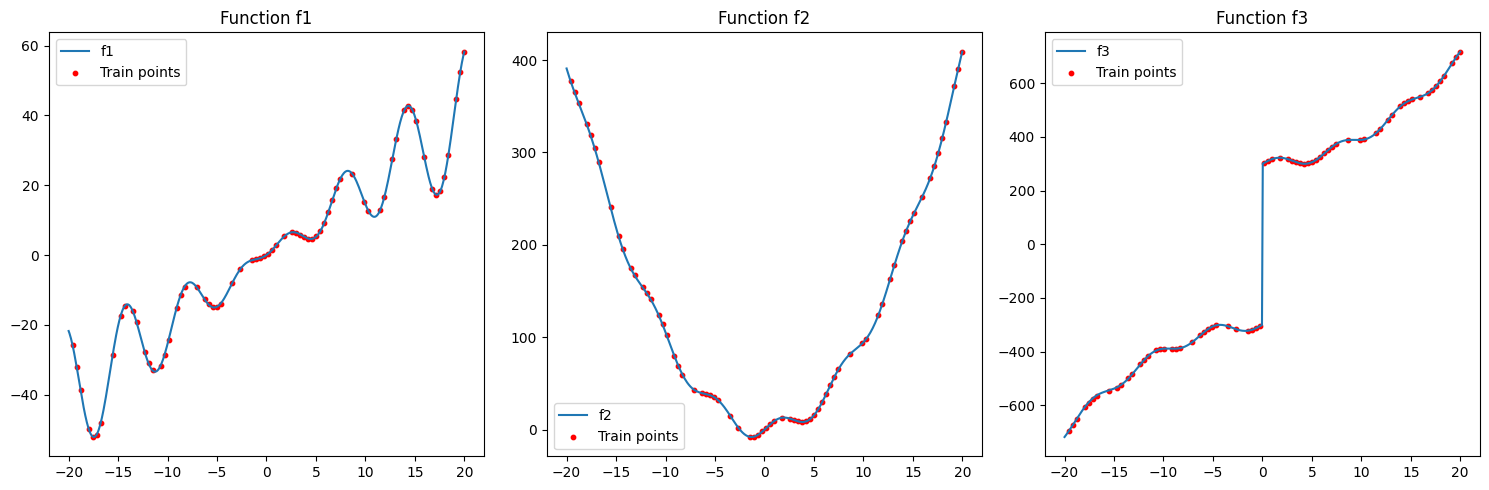

In [15]:
import matplotlib.pyplot as plt


def plot_datasets(datasets):
    plt.figure(figsize=(15, 5))
    for i, (func_name, data) in enumerate(datasets.items(), 1):  # for-each loop
        X_plot = np.linspace(-20, 20, 500)
        y_plot = data['function'](X_plot)

        plt.subplot(1, 3, i)
        plt.plot(X_plot, y_plot, label=func_name)
        plt.scatter(data['X_train'], data['y_train'], color='red', s=10, label='Train points')
        plt.title(f'Function {func_name}')
        plt.legend()
    plt.tight_layout()
    plt.show()


plot_datasets(datasets)

In [16]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score


def eval(X_train, X_test, y_train, y_test, random_state=random_state):
    models = {
        'Linear Regression': LinearRegression(),
        'Ridge Regression ': Ridge(alpha=1.0),
        'SVR (RBF)        ': SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.1),
        'MLP Regressor    ': MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=1000,
                                          random_state=random_state),
        'Random Forest    ': RandomForestRegressor(n_estimators=100, random_state=random_state),
    }

    for model_name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        print(f'{model_name}: MSE = {mse:.2f}, R2 = {r2:.2f}')


for func_name, data in datasets.items():
    print(f"\n--- {func_name} ---")
    X_train, y_train = data['X_train'].reshape(-1, 1), data['y_train']
    X_test, y_test = data['X_test'].reshape(-1, 1), data['y_test']

    eval(X_train, X_test, y_train, y_test, random_state)


--- f1 ---
Linear Regression: MSE = 57.42, R2 = 0.89
Ridge Regression : MSE = 57.41, R2 = 0.89
SVR (RBF)        : MSE = 0.32, R2 = 1.00


C:\Users\kunov\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


MLP Regressor    : MSE = 57.46, R2 = 0.89
Random Forest    : MSE = 7.01, R2 = 0.99

--- f2 ---
Linear Regression: MSE = 12926.81, R2 = -0.02
Ridge Regression : MSE = 12926.78, R2 = -0.02
SVR (RBF)        : MSE = 55.97, R2 = 1.00


C:\Users\kunov\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


MLP Regressor    : MSE = 212.63, R2 = 0.98
Random Forest    : MSE = 46.31, R2 = 1.00

--- f3 ---
Linear Regression: MSE = 13568.76, R2 = 0.93
Ridge Regression : MSE = 13569.37, R2 = 0.93
SVR (RBF)        : MSE = 3845.95, R2 = 0.98
MLP Regressor    : MSE = 1973.46, R2 = 0.99
Random Forest    : MSE = 71.59, R2 = 1.00


C:\Users\kunov\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


In [17]:
from sklearn.preprocessing import PolynomialFeatures, FunctionTransformer, StandardScaler
from sklearn.pipeline import make_pipeline


def feature_eval(datasets, random_state=random_state):
    def trig_features(X, degree=1):
        X = X.flatten()
        features = []
        for k in range(1, degree + 1):
            features.extend([np.sin(k * X), np.cos(k * X)])
        return np.column_stack(features)

    degrees = [1, 2, 3, 4]

    for func_name, data in datasets.items():
        X_train = data['X_train'].reshape(-1, 1)
        X_test = data['X_test'].reshape(-1, 1)
        y_train, y_test = data['y_train'], data['y_test']

        print(f"\n--- {func_name} with Polynomial Features ---")
        for degree in degrees:
            model = make_pipeline(
                StandardScaler(),
                FunctionTransformer(
                    lambda X: trig_features(X, degree=degree),
                    validate=False
                ),
                RandomForestRegressor(n_estimators=100, random_state=random_state)
            )
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)

            mse = mean_squared_error(y_test, y_pred)
            r2 = r2_score(y_test, y_pred)

            print(f"Degree {degree}: MSE = {mse:.2f}, R2 = {r2:.2f}")

        print(f"\n--- {func_name} with Trigonometric Features ---")
        for degree in degrees:
            model = make_pipeline(
                PolynomialFeatures(degree=degree),
                RandomForestRegressor(n_estimators=100, random_state=random_state)
            )
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)

            mse = mean_squared_error(y_test, y_pred)
            r2 = r2_score(y_test, y_pred)

            print(f"Degree {degree}: MSE = {mse:.2f}, R2 = {r2:.2f}")


feature_eval(datasets)


--- f1 with Polynomial Features ---
Degree 1: MSE = 10.67, R2 = 0.98
Degree 2: MSE = 12.72, R2 = 0.98
Degree 3: MSE = 13.11, R2 = 0.98
Degree 4: MSE = 11.47, R2 = 0.98

--- f1 with Trigonometric Features ---
Degree 1: MSE = 7.01, R2 = 0.99
Degree 2: MSE = 5.81, R2 = 0.99
Degree 3: MSE = 6.13, R2 = 0.99
Degree 4: MSE = 6.08, R2 = 0.99

--- f2 with Polynomial Features ---
Degree 1: MSE = 120.95, R2 = 0.99
Degree 2: MSE = 140.70, R2 = 0.99
Degree 3: MSE = 128.45, R2 = 0.99
Degree 4: MSE = 138.13, R2 = 0.99

--- f2 with Trigonometric Features ---
Degree 1: MSE = 46.31, R2 = 1.00
Degree 2: MSE = 63.02, R2 = 1.00
Degree 3: MSE = 75.56, R2 = 0.99
Degree 4: MSE = 68.39, R2 = 0.99

--- f3 with Polynomial Features ---
Degree 1: MSE = 93.57, R2 = 1.00
Degree 2: MSE = 78.55, R2 = 1.00
Degree 3: MSE = 75.71, R2 = 1.00
Degree 4: MSE = 71.26, R2 = 1.00

--- f3 with Trigonometric Features ---
Degree 1: MSE = 71.59, R2 = 1.00
Degree 2: MSE = 62.69, R2 = 1.00
Degree 3: MSE = 75.26, R2 = 1.00
Degree 4: 

In [42]:
from sklearn.datasets import make_regression


def create_regression_database(n_samples, n_features, n_redundant=0, noise=0.0,
                               random_state=random_state):
    X, y = make_regression(n_samples=n_samples, n_features=n_features,
                           n_informative=n_features - n_redundant,
                           random_state=random_state, shuffle=False)

    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7,
                                                        random_state=random_state)

    return X_train, X_test, y_train, y_test

In [43]:
X_train, X_test, y_train, y_test = create_regression_database(n_samples=2000, n_features=20,
                                                              noise=0)
print(f'--- Regression ---')
eval(X_train, X_test, y_train, y_test)

X_train_h, X_test_h, y_train_h, y_test_h = create_regression_database(n_samples=2000, n_features=20,
                                                                      n_redundant=n_redundant,
                                                                      noise=50.0)

print(f'\n--- Regression (Hard) ---')
eval(X_train_h, X_test_h, y_train_h, y_test_h)

lr = LinearRegression().fit(X_train_h, y_train_h)
print("\nLinear Regression Coefficients (Last 5 Redundant):")
print(lr.coef_[-n_redundant:])

--- Regression ---
Linear Regression: MSE = 0.00, R2 = 1.00
Ridge Regression : MSE = 0.04, R2 = 1.00
SVR (RBF)        : MSE = 16520.90, R2 = 0.77


C:\Users\kunov\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


MLP Regressor    : MSE = 11.68, R2 = 1.00
Random Forest    : MSE = 22729.41, R2 = 0.69

--- Regression (Hard) ---
Linear Regression: MSE = 0.00, R2 = 1.00
Ridge Regression : MSE = 0.03, R2 = 1.00
SVR (RBF)        : MSE = 10085.78, R2 = 0.78
MLP Regressor    : MSE = 11.76, R2 = 1.00
Random Forest    : MSE = 13942.38, R2 = 0.70

Linear Regression Coefficients (Last 5 Redundant):
[ 6.65581459e-14  9.91252832e-14 -2.56045185e-14  1.84297022e-14
 -5.72875081e-14]


In [61]:
import pandas as pd

df = pd.read_csv('SummaryofWeather.csv')
print(df.head())
print(df.info())

     STA      Date Precip  WindGustSpd    MaxTemp    MinTemp   MeanTemp  \
0  10001  1942-7-1  1.016          NaN  25.555556  22.222222  23.888889   
1  10001  1942-7-2      0          NaN  28.888889  21.666667  25.555556   
2  10001  1942-7-3   2.54          NaN  26.111111  22.222222  24.444444   
3  10001  1942-7-4   2.54          NaN  26.666667  22.222222  24.444444   
4  10001  1942-7-5      0          NaN  26.666667  21.666667  24.444444   

  Snowfall PoorWeather  YR  ...  FB  FTI ITH  PGT  TSHDSBRSGF  SD3  RHX  RHN  \
0      0.0         NaN  42  ... NaN  NaN NaN  NaN         NaN  NaN  NaN  NaN   
1      0.0         NaN  42  ... NaN  NaN NaN  NaN         NaN  NaN  NaN  NaN   
2      0.0         NaN  42  ... NaN  NaN NaN  NaN         NaN  NaN  NaN  NaN   
3      0.0         NaN  42  ... NaN  NaN NaN  NaN         NaN  NaN  NaN  NaN   
4      0.0         NaN  42  ... NaN  NaN NaN  NaN         NaN  NaN  NaN  NaN   

  RVG  WTE  
0 NaN  NaN  
1 NaN  NaN  
2 NaN  NaN  
3 NaN  NaN  
4 N

C:\Users\kunov\AppData\Local\Temp\ipykernel_19512\1657213098.py:3: DtypeWarning: Columns (7,8,18,25) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('SummaryofWeather.csv')


0


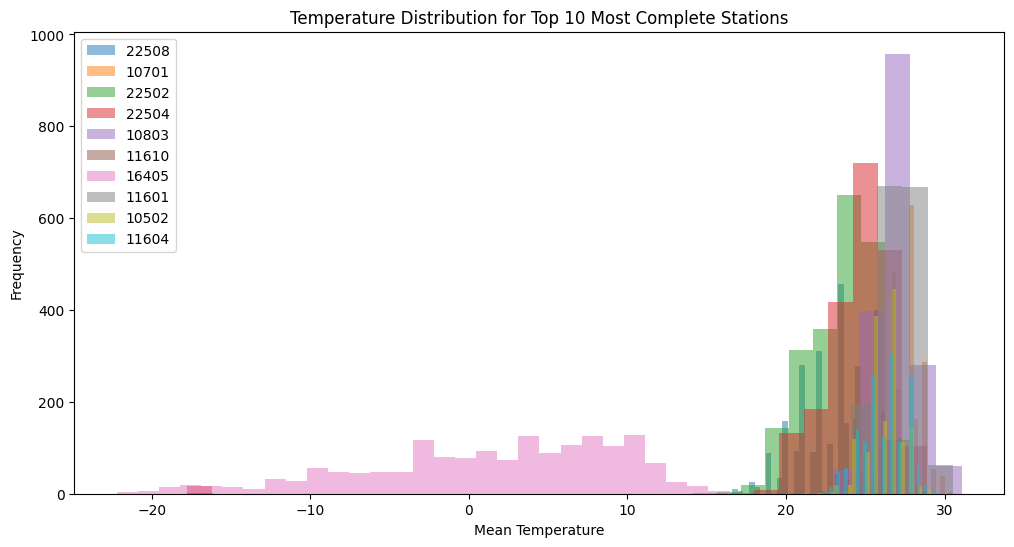

In [62]:
print(df['MeanTemp'].isna().sum())

station_completeness = df.groupby('STA')['MeanTemp'].count().sort_values(ascending=False)
top_10_stations = station_completeness.head(10).index

plt.figure(figsize=(12, 6))
for station in top_10_stations:
    station_data = df[df['STA'] == station]['MeanTemp'].dropna()
    plt.hist(station_data, bins=30, alpha=0.5, label=str(station))
plt.legend()
plt.title('Temperature Distribution for Top 10 Most Complete Stations')
plt.xlabel('Mean Temperature')
plt.ylabel('Frequency')
plt.show()

             MeanTemp
Date                 
1940-01-01  20.000000
1940-01-02  19.444444
1940-01-03  20.000000
1940-01-04  21.111111
1940-01-05  18.333333


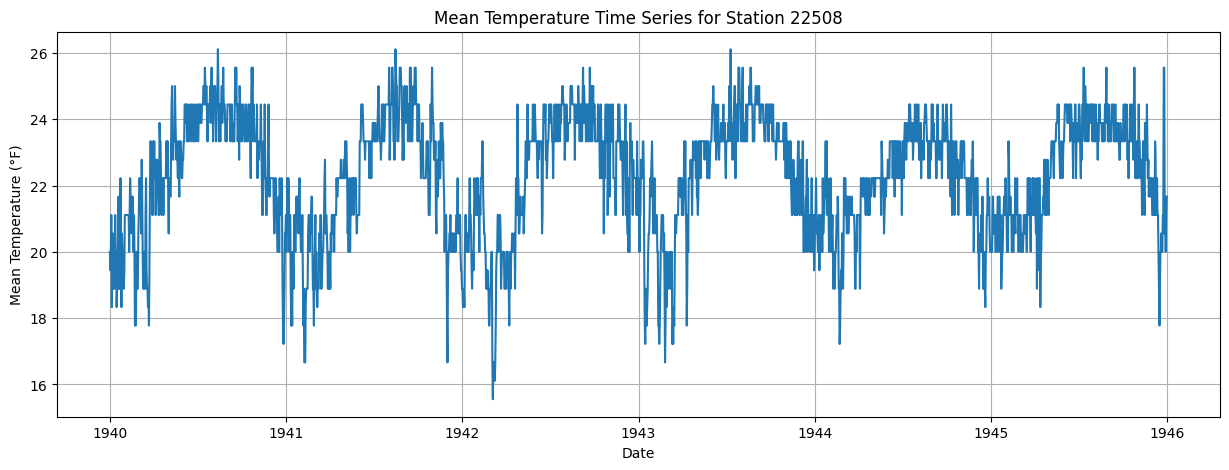

In [63]:
station_data = df[df['STA'] == 22508].copy()
station_data['Date'] = pd.to_datetime(station_data['Date'])
station_data.set_index('Date', inplace=True)
station_data = station_data[['MeanTemp']].dropna()

print(station_data.head())

plt.figure(figsize=(15, 5))
plt.plot(station_data.index, station_data['MeanTemp'])
plt.title('Mean Temperature Time Series for Station 22508')
plt.xlabel('Date')
plt.ylabel('Mean Temperature (°F)')
plt.grid(True)
plt.show()

In [64]:
def create_rolling_windows(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size - 1):
        X.append(data[i:(i + window_size)])
        y.append(data[i + window_size + 1])
    return np.array(X), np.array(y)

window_size=7
X, y = create_rolling_windows(station_data['MeanTemp'].values, window_size)

In [65]:
train_mask = station_data.index.year < 1945
test_mask = station_data.index.year == 1945

train_indices = np.where(train_mask[:-window_size-1])[0]
test_indices = np.where(test_mask[:-window_size-1])[0]

X_train, y_train = X[train_indices], y[train_indices]
X_test, y_test = X[test_indices], y[test_indices]

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

Train shape: (1827, 7), Test shape: (357, 7)


In [66]:
from sklearn.pipeline import Pipeline

models = {
    'Linear Regression': Pipeline([('scaler', StandardScaler()),
                                 ('model', LinearRegression())]),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=random_state),
    'Neural Network': Pipeline([('scaler', StandardScaler()),
                              ('model', MLPRegressor(hidden_layer_sizes=(50,),
                                                    max_iter=1000, random_state=random_state))])
}

results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)

    results[name] = {'r2': r2, 'mse': mse}

    print(f"{name}: R2 = {r2:.4f}, MSE = {mse:.4f}")

best_model_name = max(results, key=lambda x: results[x]['r2'])
print(f"\nBest model: {best_model_name}")

Linear Regression: R2 = 0.5977, MSE = 0.9320
Random Forest: R2 = 0.5204, MSE = 1.1111
Neural Network: R2 = 0.5486, MSE = 1.0457

Best model: Linear Regression


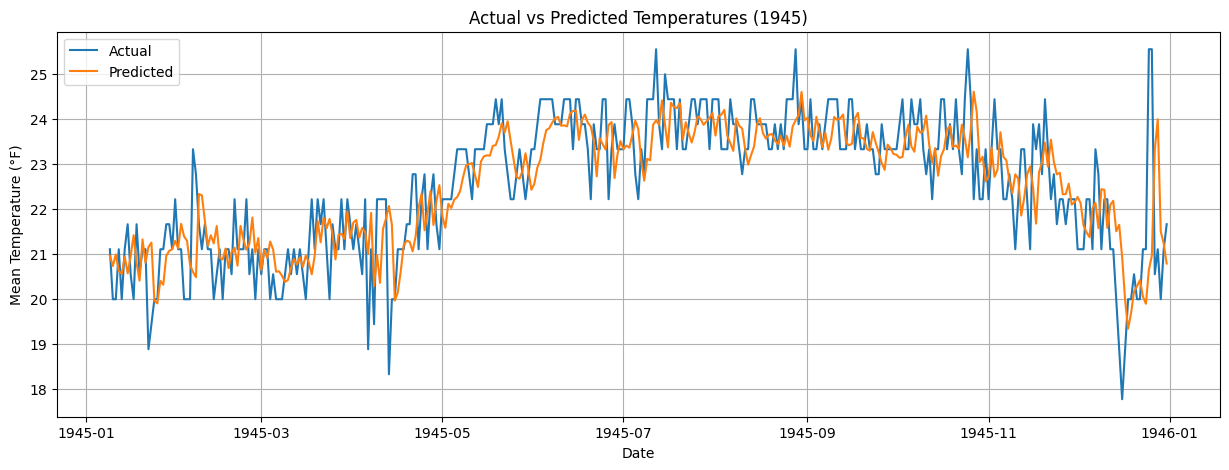

In [67]:
best_model = models[best_model_name]
y_pred = best_model.predict(X_test)

plt.figure(figsize=(15, 5))
plt.plot(station_data[test_mask].index[window_size+1:], y_test, label='Actual')
plt.plot(station_data[test_mask].index[window_size+1:], y_pred, label='Predicted')
plt.title('Actual vs Predicted Temperatures (1945)')
plt.xlabel('Date')
plt.ylabel('Mean Temperature (°F)')
plt.legend()
plt.grid(True)
plt.show()

In [68]:
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

rf = RandomForestRegressor(random_state=random_state)
grid_search = GridSearchCV(rf, param_grid, cv=TimeSeriesSplit(n_splits=3),
                          scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

best_rf = grid_search.best_estimator_
y_pred_rf = best_rf.predict(X_test)

print(f"Tuned RF R2: {r2_score(y_test, y_pred_rf):.4f}")
print(f"Tuned RF MSE: {mean_squared_error(y_test, y_pred_rf):.4f}")

Tuned RF R2: 0.5707
Tuned RF MSE: 0.9945
